In [1]:
import sys
sys.path.insert(0, '..')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import JAX instead of numpy
import jax.numpy as np
import jax.random as rand
from jax import jit, vmap, grad

# Import modified version of challenge metrics
from tomo_challenge import jax_metrics as metrics

# Import tools from jax-cosmo
from jax_cosmo.redshift import kde_nz

## Loading the data

In [3]:
from tomo_challenge.data import load_magnitudes_and_colors, load_redshift
from sklearn.preprocessing import StandardScaler
features_scaler = StandardScaler()

features = np.array( features_scaler.fit_transform(load_magnitudes_and_colors('../riz/training.hdf5','riz')))
labels = np.array(load_redshift('../riz/training.hdf5'))

../tomo_challenge/data.py:70: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(filename)
../tomo_challenge/data.py:94: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")
/home/francois/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
../tomo_challenge/data.py:117: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the envi

In [4]:
# Let's grab some data
batch_size = 10000
# Let's grab some data
batch_labels = labels[:batch_size]
batch_features = features[:batch_size]

In [5]:
nz = kde_nz(zcat=batch_labels, bw=0.1)

Text(0.5, 0, 'redshift z')

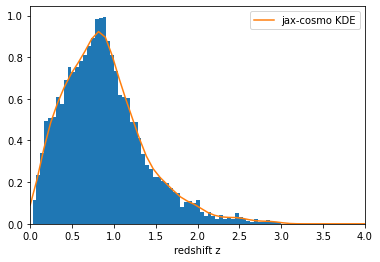

In [6]:
z = np.linspace(0,4)
hist(batch_labels, 64, density=True)
plot(z, nz(z), label='jax-cosmo KDE')
xlim(0,4)
legend()
xlabel('redshift z')

## Create a neural network classifier

In [7]:
from flax import nn
from flax import optim

In [8]:
nbins=2
# Here is a trivial classifier for 2 bins
class BinningNN(nn.Module):
    def apply(self, x):
        """
        Takes as an input the features to use for binning
        """
        net = nn.Dense(x, 500, name='fc1')
        net = nn.leaky_relu(net)
        net = nn.Dense(net, 500, name='fc2')
        net = nn.leaky_relu(net)
        # The output of the model should be a gumbell softmax layer
        return nn.softmax(nn.Dense(net, nbins))

In [9]:
@jit
def train_step(optimizer, batch):
    def loss_fn(model):
        w = model(batch['features'])
        
        # Let's add a soft constraint that all bins
        # should have more or less the same number of gals
        #gals_per_bins_loss = (np.mean(w, axis=0) - np.ones(nbins)/nbins)**2

        return -metrics.compute_snr_score(w, batch['labels']) #+ 1000* np.sum(gals_per_bins_loss)
    g = grad(loss_fn)(optimizer.target)
    optimizer = optimizer.apply_gradient(g)
    return optimizer

In [10]:
@jit
def eval(model, batch):
    w = model(batch['features'])
    return -metrics.compute_snr_score(w, batch['labels'])

In [11]:
# Let's get some initial weights
_, initial_params = BinningNN.init_by_shape( rand.PRNGKey(0), [((1, 6), np.float32)])
model = nn.Model(BinningNN, initial_params)

In [41]:
optimizer = optim.Momentum(learning_rate=0.001, beta=0.9).create(model)

In [42]:
import numpy as onp
batch_size = 2000
def get_batch():
    inds = onp.random.choice(len(labels), batch_size)
    return {'labels': labels[inds], 'features': features[inds]}

In [43]:
eval(optimizer.target, get_batch())

DeviceArray(135.59447, dtype=float32)

In [44]:
losses = []

In [61]:
for i in range(10):
    batch = get_batch()
    optimizer = train_step(optimizer, batch)
    l = eval(optimizer.target, batch)
    if i%1 == 0:
        losses.append(l)
        print('Loss : %f'%l)

Loss : 131.768784
Loss : 130.612610
Loss : 134.933838
Loss : 133.706955
Loss : 131.758331
Loss : 129.752411
Loss : 128.282532
Loss : 129.528488
Loss : 131.731949
Loss : 128.285233


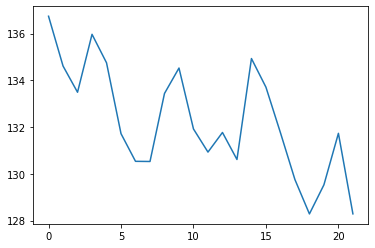

In [62]:
plot(losses)

In [63]:
# Sweet :-D let's see if it did anything
w  = optimizer.target(batch['features'])
nzs = [kde_nz(zcat=batch['labels'], weight=w[:,i], bw=0.1, zmax=4.) for i in range(nbins)]

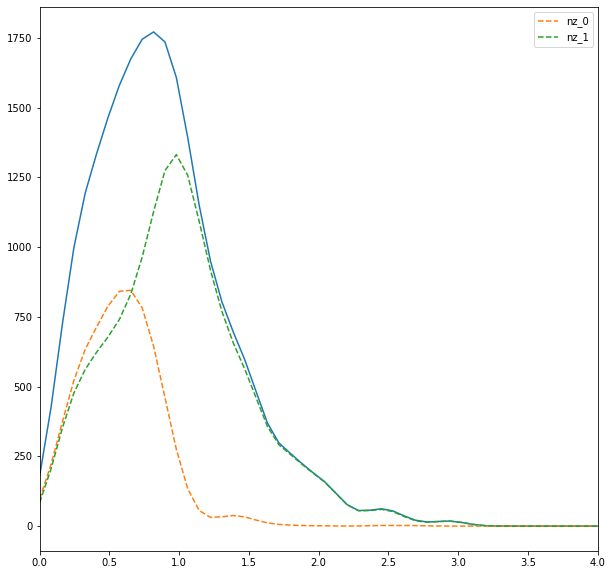

In [64]:
figure(figsize=(10,10))
z = np.linspace(0,4)
nz_total = kde_nz(zcat=batch['labels'], bw=0.1)
plot(z, nz_total(z)*len(nz_total._params['zcat']))
for i, nz in enumerate(nzs):
    plot(z, nz(z)*nz._params['weight'].sum(), '--', label='nz_%d'%i)
xlim(0,4)
legend()

In [57]:
from tomo_challenge import metrics as ometrics

In [60]:
ometrics.compute_snr_score(np.argmax(w,axis=-1), batch['labels'])

-132.54779241161057